<a href="https://colab.research.google.com/github/aekomissarova/dog_breed_classification/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of dog breeds - https://www.kaggle.com/c/dog-breed-identification/overview 

In [1]:
#!unzip "/content/drive/MyDrive/dog_breed_classification/dog-breed-identification.zip" -d "/content/drive/MyDrive/dog_breed_classification"

In [2]:
# Import tensorFlow
import tensorflow as tf
print("TF version", tf.__version__)

TF version 2.9.2


In [3]:
#Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

TF Hub version: 0.12.0


In [4]:
#Check for GPU availability
print("GPU:","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU: not available


In [5]:
#Prepare data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

labels = pd.read_csv("/content/drive/MyDrive/dog_breed_classification/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


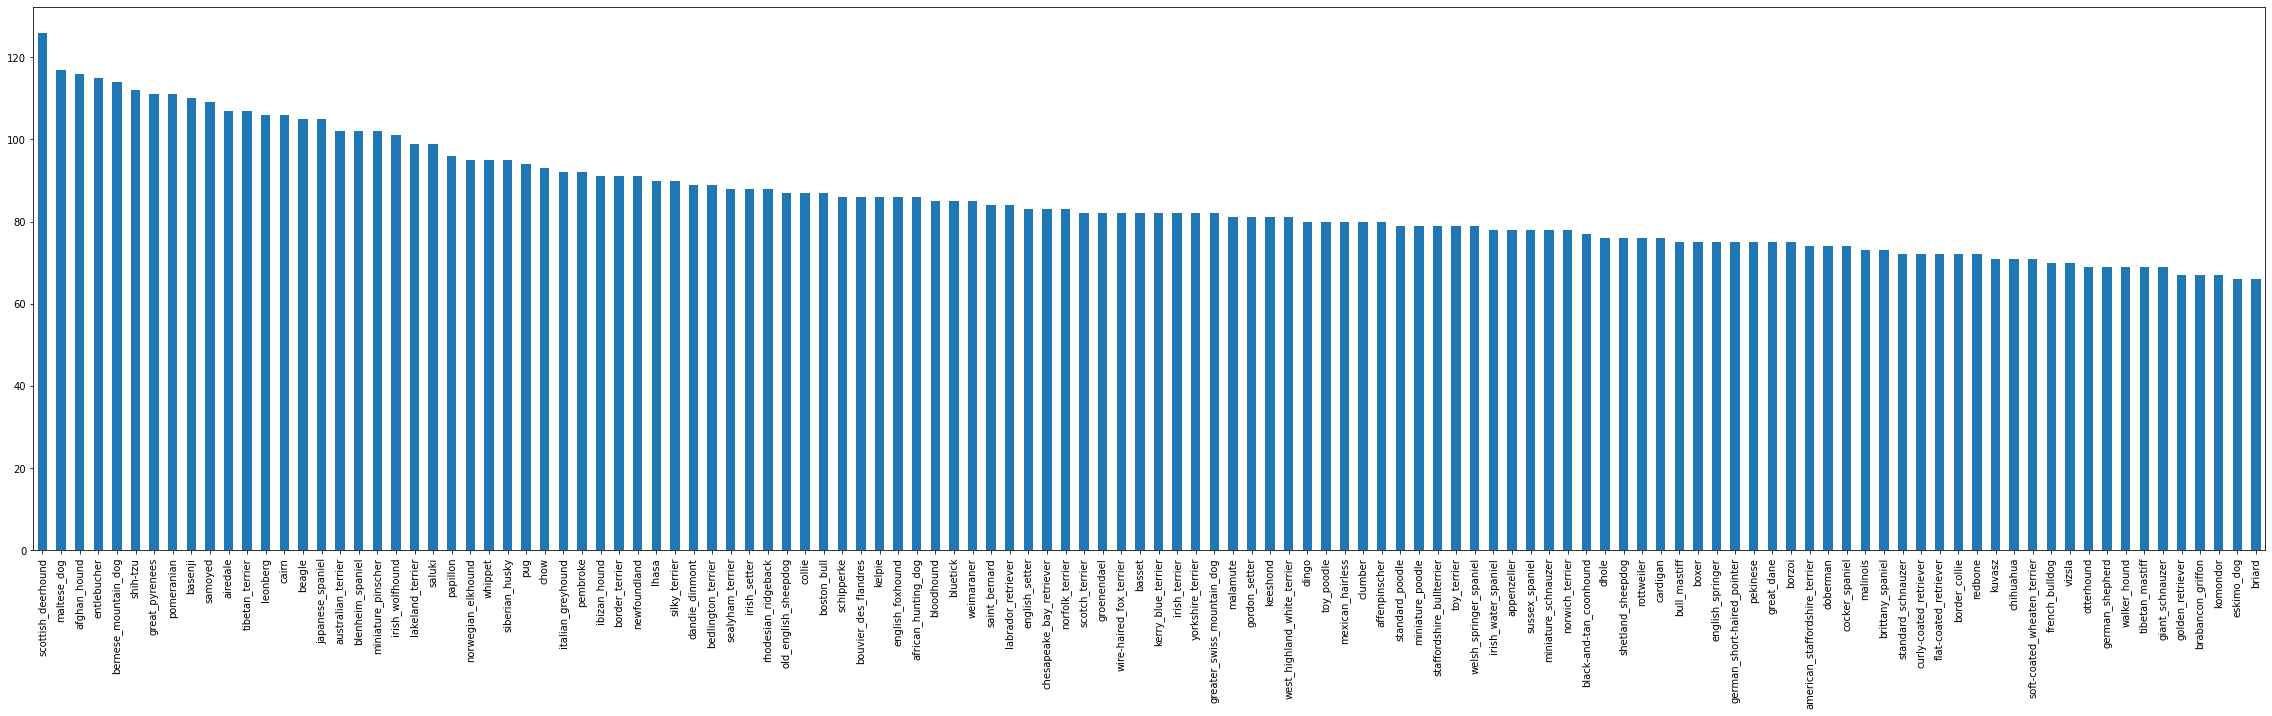

In [6]:
#How many pictures do we have for each breed?
labels["breed"].value_counts().plot.bar(figsize = (40,10))

In [7]:
labels["breed"].value_counts().median()

82.0

In [8]:
labels["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

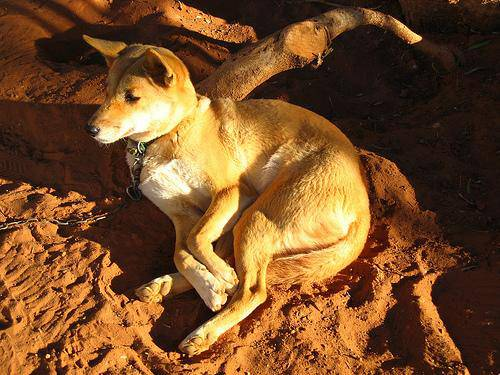

In [49]:
#View an image
from IPython.display import Image
Image(data = "/content/drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [29]:
#Get a list of all images pathnames
train_directory = "drive/MyDrive/dog_breed_classification/train/"


filenames = [train_directory + fname + ".jpg" for fname in labels["id"]]
filenames[:5]


['drive/MyDrive/dog_breed_classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_breed_classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_breed_classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_breed_classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [30]:
# Verify our results for filenames

import os
if len([os.path.join(train_directory,file) for file in os.listdir(train_directory)]) == len(filenames):
  print("Filenames are correct")
else:
  print("Filenames are not correct")

Filenames are correct


In [ ]:
Image(data = filenames[1000])

In [31]:
labels_new = labels["breed"].to_numpy() # convert labels column to NumPy array
unique_breeds = np.unique(labels_new)

boolean_labels = [label == np.array(unique_breeds) for label in labels_new]
boolean_labels[:2]
X = filenames
y = boolean_labels
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}


In [32]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [33]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [34]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [35]:
# Function to return tuples of labels and images
def get_image_label(image_path, label):
  """
  Return the image with its label
  """
  image = process_image(image_path)
  return image, label

In [36]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [37]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [38]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [45]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

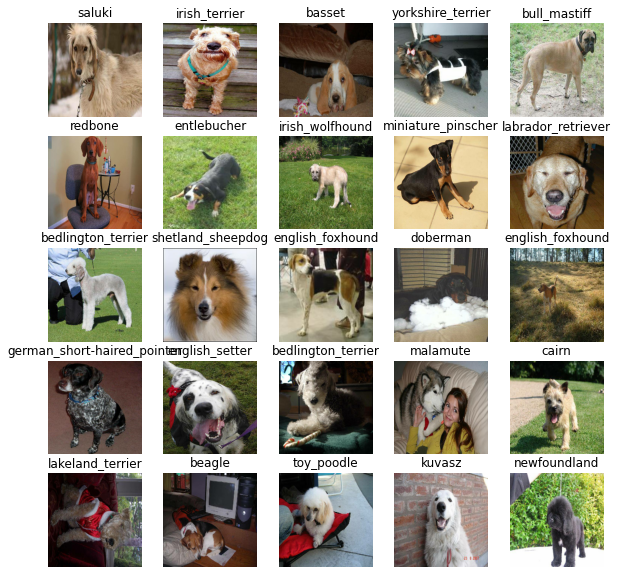

In [46]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

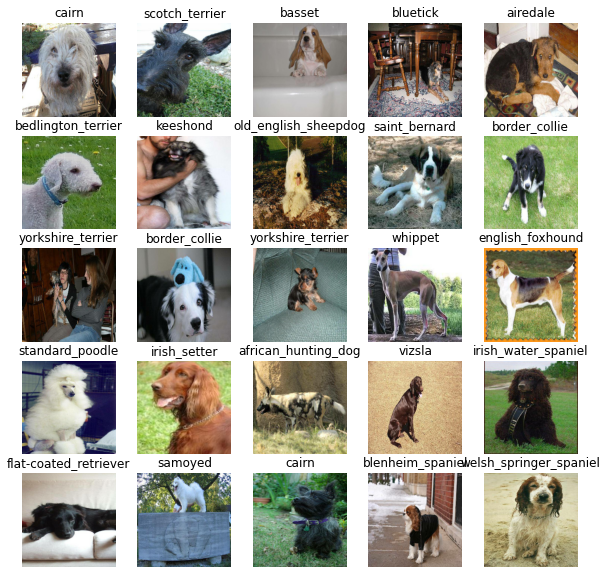

In [52]:
val_images, val_label = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_label)

In [54]:
# Building a model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds)

# Use the model from tensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"



In [56]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Creating a model ...")

  model = tf.keras.Sequential([hub.KerasLayer(model_url),
                               tf.keras.layers.Dense(units = output_shape,
                                                     activation = "softmax")
  ])

  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  model.build(input_shape)
  return model

In [57]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
